# Predicting housing prices 
 
The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').

In this homework we'll again use the California Housing Prices dataset - the same one we used in homework 2 and 3.

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
# reading dataset
PATH = "./housing.csv"
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv(PATH, usecols=select_cols)
df.total_bedrooms = df.total_bedrooms.fillna(0)

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
# applying the log transform to median_house_value
df.median_house_value = np.log1p(df.median_house_value)

In [5]:
# split of the data
full_train_df, test_df = train_test_split(df, test_size=0.2, random_state=1)

In [6]:
full_train_df.shape, test_df.shape

((16512, 10), (4128, 10))

In [7]:
train_df, val_df = train_test_split(full_train_df, test_size=0.25, random_state=1)

In [8]:
train_df.shape, val_df.shape

((12384, 10), (4128, 10))

In [9]:
y_train = train_df.median_house_value.values
y_val = val_df.median_house_value.values
y_test = test_df.median_house_value.values

del train_df['median_house_value']
del val_df['median_house_value']
del test_df['median_house_value']

In [10]:
train_dict = train_df.to_dict(orient='records')
val_dict = val_df.to_dict(orient='records')
test_dict = test_df.to_dict(orient='records')

In [11]:
dv = DictVectorizer(sparse=False)

In [12]:
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)

In [13]:
X_train

array([[ 578.  ,   19.  ,   34.63, ..., 1677.  ,  606.  , 3562.  ],
       [  50.  ,   10.  ,   34.69, ...,  108.  ,  102.  ,  337.  ],
       [ 462.  ,   27.  ,   33.78, ..., 1723.  ,  491.  , 1672.  ],
       ...,
       [ 854.  ,   18.  ,   33.9 , ..., 2276.  ,  922.  , 3380.  ],
       [ 415.  ,   41.  ,   36.78, ..., 1129.  ,  462.  , 2227.  ],
       [ 589.  ,    9.  ,   34.02, ..., 2280.  ,  587.  , 4265.  ]])

## Question 1. Which feature is used for splitting the data?

### ocean_proximity=INLAND

In [14]:
dtr = DecisionTreeRegressor(max_depth=1)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [15]:
print(export_text(dtr, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



/home/ls/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Question 2. What's the RMSE of this model on validation?

### 0.25

In [16]:
rfr = RandomForestRegressor(n_estimators=10,
                           random_state=1, 
                           n_jobs=-1)
rfr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [17]:
y_pred = rfr.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(round(rmse, 2))

0.25


## Question 3. After which value of n_estimators does RMSE stop improving?

### 150

In [18]:
scores = []

for n in range(10, 200, 10):
    rfr = RandomForestRegressor(n_estimators=n,
                           random_state=1, 
                           n_jobs=-1)
    rfr.fit(X_train, y_train)
    
    y_pred = rfr.predict(X_val)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, rmse))

In [19]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
df_scores

,n_estimators,rmse
0,10,0.245660
1,20,0.238831
2,30,0.235335
3,40,0.234257
4,50,0.232991
5,60,0.232767
6,70,0.232337
7,80,0.232403
8,90,0.232107
9,100,0.231928


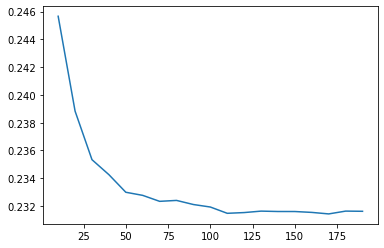

In [20]:
plt.plot(df_scores['n_estimators'], df_scores['rmse'])

## Question 4. What's the best max_depth?

### 25

In [21]:
scores = []

for max_depth in [10, 15, 20, 25]:
    for n in range(10, 200, 10):
        rfr = RandomForestRegressor(n_estimators=n,
                                    max_depth=max_depth,
                                    random_state=1, 
                                    n_jobs=-1)
        rfr.fit(X_train, y_train)

        y_pred = rfr.predict(X_val)

        rmse = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((n, max_depth, rmse))
        
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'max_depth', 'rmse'])
df_scores

,n_estimators,max_depth,rmse
0,10,10,0.254599
1,20,10,0.252577
2,30,10,0.251463
3,40,10,0.250919
4,50,10,0.250069
...,...,...,...
71,150,25,0.231504
72,160,25,0.231485
73,170,25,0.231436
74,180,25,0.231552


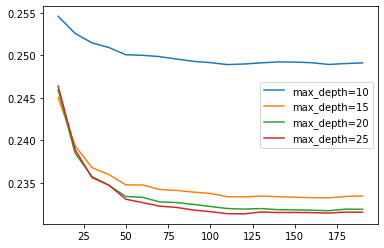

In [22]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % d)

plt.legend()

## Question 5.

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

### median_income

In [23]:
rfr = RandomForestRegressor(n_estimators=10,
                            max_depth=20,
                            random_state=1, 
                            n_jobs=-1)
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [24]:
len(rfr.feature_importances_)

13

In [25]:
rfr.feature_importances_

array([1.63873827e-02, 3.31454580e-02, 1.01255849e-01, 9.64702137e-02,
       3.63325843e-01, 2.48880276e-03, 3.10900842e-01, 3.56806263e-04,
       4.80369796e-04, 4.69876693e-03, 3.07769212e-02, 1.91716318e-02,
       2.05411131e-02])

<BarContainer object of 13 artists>

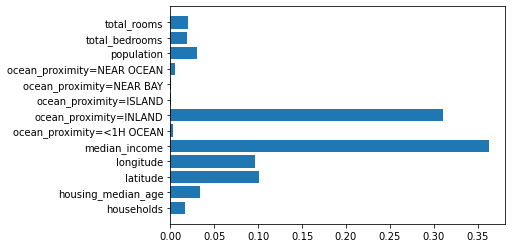

In [26]:
plt.barh(dv.get_feature_names_out(), rfr.feature_importances_)

## Question 6. Which eta leads to the best RMSE score on the validation dataset?

### 0.3

In [27]:
features = dv.get_feature_names()

/home/ls/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [28]:
features

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=<1H OCEAN',
 'ocean_proximity=INLAND',
 'ocean_proximity=ISLAND',
 'ocean_proximity=NEAR BAY',
 'ocean_proximity=NEAR OCEAN',
 'population',
 'total_bedrooms',
 'total_rooms']

In [29]:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [30]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [45]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [46]:
y_pred = model.predict(dval)
y_pred

array([12.785514 , 13.082328 , 11.485188 , ..., 12.787802 , 12.4473295,
       12.275799 ], dtype=float32)

In [47]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(rmse)

0.2260957847928297


In [38]:
s = output.stdout
print(s)

[0]	train-rmse:8.12733	val-rmse:8.13245
[5]	train-rmse:1.40218	val-rmse:1.40741
[10]	train-rmse:0.34481	val-rmse:0.35782
[15]	train-rmse:0.23555	val-rmse:0.26044
[20]	train-rmse:0.21580	val-rmse:0.24624
[25]	train-rmse:0.20395	val-rmse:0.24099
[30]	train-rmse:0.19440	val-rmse:0.23741
[35]	train-rmse:0.18637	val-rmse:0.23562
[40]	train-rmse:0.17983	val-rmse:0.23419
[45]	train-rmse:0.17468	val-rmse:0.23279
[50]	train-rmse:0.16934	val-rmse:0.23097
[55]	train-rmse:0.16546	val-rmse:0.23039
[60]	train-rmse:0.16177	val-rmse:0.22950
[65]	train-rmse:0.15762	val-rmse:0.22857
[70]	train-rmse:0.15323	val-rmse:0.22787
[75]	train-rmse:0.15010	val-rmse:0.22755
[80]	train-rmse:0.14564	val-rmse:0.22611
[85]	train-rmse:0.14166	val-rmse:0.22579
[90]	train-rmse:0.13892	val-rmse:0.22628
[95]	train-rmse:0.13553	val-rmse:0.22630
[99]	train-rmse:0.13299	val-rmse:0.22610



In [39]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [40]:
df_score = parse_xgb_output(output)
df_score.describe()

,num_iter,train_rmse,val_rmse
count,21.000000,21.000000,21.000000
mean,49.952381,0.615103,0.670990
std,30.944266,1.742439,1.728713
min,0.000000,0.132990,0.225790
25%,25.000000,0.150100,0.227550
50%,50.000000,0.169340,0.230970
75%,75.000000,0.203950,0.240990
max,99.000000,8.127330,8.132450


In [48]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [50]:
y_pred = model.predict(dval)
y_pred

array([12.671502 , 13.0838995, 11.628285 , ..., 12.756049 , 12.402419 ,
       12.324607 ], dtype=float32)

In [51]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(rmse)

0.2305416021993131


In [42]:
df_score = parse_xgb_output(output)
df_score.describe()

,num_iter,train_rmse,val_rmse
count,21.000000,21.000000,21.000000
mean,49.952381,1.340280,1.364946
std,30.944266,2.558293,2.549250
min,0.000000,0.183290,0.230540
25%,25.000000,0.196800,0.235070
50%,50.000000,0.226140,0.253340
75%,75.000000,0.799330,0.806570
max,99.000000,10.443720,10.449380


In [ ]:
mean_squared_error